In [117]:
import os
import torch
from torchvision.datasets import CIFAR100, CIFAR10
from transformers import DistilBertTokenizer
from dataset import get_transforms
from CLIP import CLIPModel
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/data/yuto/clip/OpenAI-CLIP/output/resnet_text_encoder_fix/checkpoints/checkpoint_3.pth"

model = CLIPModel().to("cuda")
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [15]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [10]:
transforms = get_transforms(mode='valid')

In [118]:
# Download the dataset
cifar100 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [17:01<00:00, 166873.65it/s]


Extracting /data/yuto/.cache/cifar-10-python.tar.gz to /data/yuto/.cache


In [ ]:
text_inputs = tokenizer([f"a photo of a {c}" for c in cifar100.classes], padding=True, return_tensors='pt').to(device)

cloud


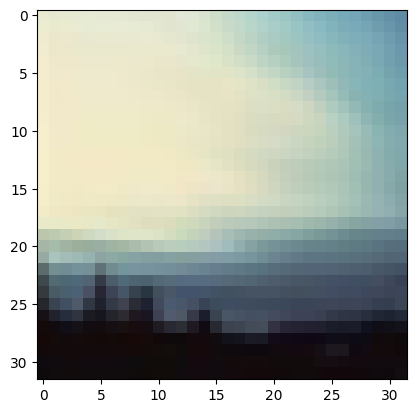

In [111]:
# Prepare the inputs
image, class_id = cifar100[8]
plt.imshow(image)
# image_input = transforms(image).unsqueeze(0).to(device)
print(cifar100.classes[class_id])
image = np.array(image)
image = transforms(image=image)['image']
image_input = torch.tensor(image).permute(2, 0, 1).float().unsqueeze(0).to(device)

In [112]:
# Calculate features
with torch.no_grad():
    image_features = model.image_encoder(image_input)
    text_features = model.text_encoder(input_ids=text_inputs["input_ids"], attention_mask=text_inputs["attention_mask"])
    image_embeddings = model.image_projection(image_features)
    text_embeddings = model.text_projection(text_features)

In [113]:
image_features.shape
text_features.shape

torch.Size([100, 768])

In [114]:
# Pick the top 5 most similar labels for the image
image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_embeddings @ text_embeddings.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [115]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

             ray: 60.34%
           cloud: 24.64%
             sea: 6.59%
          forest: 6.46%
       butterfly: 1.00%
